<a href="https://colab.research.google.com/github/xunxunshi/Predicting-Authorship/blob/main/Predicting_for_Book_Authors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 

import pandas as pd  
import re
import regex as re
import wordcloud
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from collections import Counter
from numpy.random import default_rng
import spacy
from nltk.corpus import gutenberg
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix,classification_report
from scipy.sparse import csr_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn import metrics 
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# download gutenberg to access the digital text books
nltk.download('gutenberg')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

### Function to return partitioned book as a dataframe with 200 rows , each row containing 100 words 
####  1) We use the word_tokenize package from nltk to tokenize the package 
####  2) Using a while loop, we partition the book until the end of passage : 
* We grab 100 of the next token at a time 
* Using regex, we then calculate the number of tokens (n) out of the 100 that are not words but rather punctuations etc. 
* However, it is possible that the next(n) tokens also have some punctuations. So we look ahead and once again we calculate the number of tokens(n2) that are not words 
* We repeat this to get the index (100+n+n2+..) that would allow for 100 words in the passage. 
* This passage is then added onto the BookDf dataframe. 
* We repeat this process from the previous index counter. 

#### 3) If the dataframe has less than 200 rows, this means that there were not enough number of words in the book (<20000) for 200 partitions of 100 words each. This function will still return a dataframe back but gives a warning. 
#### 4) If the total length has greater than 200 rows, we used numpy's random number generator to get200  random non-repeating numbers between 0 and max number of book rows. We then return this book back to the user. 

In [ ]:
def returnLabeledBook(text, bookName):
    Counter=0
    doc=word_tokenize(text)
    BookDf=pd.DataFrame(columns={'passage'})
    while((Counter+101)<len(doc)):
        
        tempdoc=" ".join(str(item) for item in doc[Counter:100+Counter])

        lengthOfNonWords=len(re.findall(r'\W\s+',tempdoc)) ## length of anything that is not a word or punctuation in the first 100 tokens
        ## i.e if there are 20 tokens that are punctuations out of 100, we should add another 20 tokens
        if((100+Counter+lengthOfNonWords)<len(doc)):
            # we do additional check to see how many punctuations are there in these additional tokens
            additionalWord=" ".join(str(item) for item in doc[100+Counter:100+Counter+lengthOfNonWords])
            lengthofNonwordsInAdditional=len(re.findall(r'\W\s+',additionalWord))
            if((100+Counter+lengthOfNonWords+lengthofNonwordsInAdditional)<len(doc)):
                
                asjustedDoc=" ".join(str(item) for item in doc[Counter:100+Counter+lengthOfNonWords+lengthofNonwordsInAdditional])
                BookDf.loc[len(BookDf)]=asjustedDoc
                Counter=Counter+lengthOfNonWords+100+lengthofNonwordsInAdditional
            else:
                break
        else:
            break
    BookDf['bookName']=bookName
    if(len(BookDf)<200): ## if there is less than 200 partions 
        print('Warning: The book has less than 20000 words and can not be split into a passage of 200 parts of 100 words.')
        return BookDf
    else:
        rng=default_rng() 
        numbers=rng.choice(len(BookDf),size=200,replace=False)
        print('We have succesfully partioned your book '+bookName+' into 200 random partitions of 100 words each. \n')
        print('Please note that there was a total of '+str(len(BookDf))+' partitions available, and the dataframe index represents the ordered part that were taken out. ')
        return BookDf.iloc[numbers] 

In [ ]:

df1=pd.DataFrame()
 
df1= returnLabeledBook(nltk.corpus.gutenberg.raw('chesterton-thursday.txt'),'chesterton-thursday')
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('carroll-alice.txt'), 'carroll-alice'))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('shakespeare-hamlet.txt'), 'shakespeare-hamlet'))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('bryant-stories.txt'),'bryant-stories'))
df1=df1.append(returnLabeledBook(nltk.corpus.gutenberg.raw('milton-paradise.txt'),'milton-paradise'))

We have succesfully partioned your book chesterton-thursday into 200 random partitions of 100 words each. 

Please note that there was a total of 587 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book carroll-alice into 200 random partitions of 100 words each. 

Please note that there was a total of 274 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book shakespeare-hamlet into 200 random partitions of 100 words each. 

Please note that there was a total of 302 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partioned your book bryant-stories into 200 random partitions of 100 words each. 

Please note that there was a total of 468 partitions available, and the dataframe index represents the ordered part that were taken out. 
We have succesfully partione

In [ ]:
df1

,passage,bookName
212,take your head home and boil it for a turnip i...,chesterton-thursday
145,that this was the man whom he was meant to mee...,chesterton-thursday
220,; and although he knew it was nevertheless an ...,chesterton-thursday
30,", rose to his feet . To his astonishment , he ...",chesterton-thursday
334,"to silence , but he pointed with one gloved fi...",chesterton-thursday
...,...,...
0,[ Paradise Lost by John Milton 1667 ] Book I O...,milton-paradise
529,supper comes unearned ? To whom mild answer Ad...,milton-paradise
245,". Fair Consort , the hour Of night , and all t...",milton-paradise
611,"God , Approaching , thus to Adam called aloud ...",milton-paradise


In [ ]:
df1['bookName'].value_counts()

carroll-alice          200
shakespeare-hamlet     200
chesterton-thursday    200
milton-paradise        200
bryant-stories         200
Name: bookName, dtype: int64

###**In order to retain the same results each time the jupyter notebook is rerun, we are loading the data set from books.xlsx excel file. If there is an error in loading data from this excel, then different results that do not match with the documentation might be shown due to the randomness created by the above function.**

In [ ]:
df1 = pd.read_excel('books.xlsx')

# Preprocessing: 
### Getting rid of the punctuations and Spacy Lemmatization 


*  Our choice of Spacy libary was motivated by the fact that it can perform tokenization in 0.2 milliseconds compared to nltk's 4 milliseconds.
* We are performing a lemmatization in the below code. It is a process of converting many different forms of a word such as building, built, build etc. to its base form or lemma Ex.'build', based on the context of the words surrounding it. 
* The nlp pipeline created using Spacy will automatically perform the tokenization, parsing and tagging processes for us. The preprocessing on the passages has increased the accuracy of the models to some extent.
* We are not removing stopwords during preprocessing because in past century books such as Shakespeare's Hamlet, stop words could serve as keywords to help distinguish the books. Removing them could potentially reduce the accuracy of the model in classifying such books.


In [ ]:
def return_split(passage):
  return (re.sub(r'[^\w\s]', '', str(passage).lower().strip()))

In [ ]:
df1['passage']=df1['passage'].apply(return_split)

In [ ]:
nlp=spacy.load('en_core_web_sm')

In [ ]:
def lemmatization(x):
  X_list=[]
  for token in nlp(x):
    lemma=token.text
    X_list.append(lemma)
  return " ".join(X_list)

In [ ]:
df1['passage']=df1['passage'].apply(lemmatization)

### Performing the Training/Testing Data Split on the book partitions dataframe

In [ ]:
x=df1['passage']

In [ ]:
y=df1['bookName']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7,random_state=42)

# Feature Selection : 
As a first choice, we are using TF-IDF to transform our X (Passages) into vectors 
* TF-IDF is a vectorization algorithm which is used to represent textual data in numerical vectors which can then be used to fit to the machine learning model. It gives weightage to the words depending on their relevance.
* The 'Fit' is used to identify the vocabulary and frequency whereas the 'Transform' is used for conversion to a vector.

In [ ]:
vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x_train) 
tfidf_test_data = vec.transform(x_test)

# SVC Algorithm with TF-IDF
The purpose of a Linear SVC i.e Support Vector Classifier is to return a  hyperplane that serves as the best fit to the data that we provide by properly categorizing our data.
## Hyper parameter tuning 
* We are performing hyper parameter tuning on:
 * C
 * type of loss 
* The parameter C (also known as the penalty parameter), identifies how much the model should care about getting all the classifications right with a narrow margin or making sure that the classifications done are absolutely right with a wider margin. The higher the value of C, the lesser the width of the margin.

## Grid search and cross validation 
* We use a grid search to identify the best combination of the parameters for which the model perfectly fits the data.
*  During this grid search we try each of the parameter combination on 10-fold cross validation 
*  In cross validation we are splitting the training data again into 10 seperate parts, and holding one part out for testing each time. 

In [ ]:
SVCparameters = {
  'C':[1,2,3,4,5,6,7,8,9,10],
  'loss': ['squared_hinge','hinge'], 
  }
clf=LinearSVC(random_state=101) 
grid_search=GridSearchCV(clf,SVCparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(tfidf_train_data,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=101, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'loss': ['squared_hinge', 'hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

#### The following function concatenates the grid_search results into a more readable dataframe with the below results 
 * test scores of CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10
 * train scores of CV1,CV2,CV3,CV4,CV5,CV6,CV7,CV8,CV9,CV10
 * average train score from 10 fold cross validation
 * average test score from 10 fold cross validation
 * The corresponding parameter combinations for these features
 

In [ ]:
def gridsearchResultstoDf(grid_search):
    results=pd.DataFrame(columns={'mean test score','mean train score','param', 'CV1 train loss','CV1 test loss', 'CV2 train loss','CV2 test loss', 'CV3 train loss','CV3 test loss',  'CV4 train loss','CV4 test loss', 'CV5 trainloss','CV5 test loss','CV6 train loss','CV6 test loss','CV7 train loss','CV7 test loss','CV8 train loss','CV8 test loss','CV9 train loss','CV9 test loss','CV10 train loss','CV10 test loss' })
    results=results[['mean test score','mean train score','param' , 'CV1 train loss','CV1 test loss', 'CV2 train loss','CV2 test loss', 'CV3 train loss','CV3 test loss',  'CV4 train loss','CV4 test loss', 'CV5 trainloss','CV5 test loss','CV6 train loss','CV6 test loss','CV7 train loss','CV7 test loss','CV8 train loss','CV8 test loss','CV9 train loss','CV9 test loss','CV10 train loss','CV10 test loss' ]]
    for mean_test_score,mean_train_score,params,testsplit0,testsplit1,testsplit2,testsplit3,testsplit4,testsplit5,testsplit6,testsplit7,testsplit8,testsplit9,trainsplit0,trainsplit1,trainsplit2,trainsplit3,trainsplit4,trainsplit5,trainsplit6,trainsplit7,trainsplit8,trainsplit9 in zip(grid_search.cv_results_["mean_test_score"],grid_search.cv_results_["mean_train_score"],grid_search.cv_results_["params"],grid_search.cv_results_["split0_test_score"],grid_search.cv_results_["split1_test_score"],grid_search.cv_results_["split2_test_score"],grid_search.cv_results_["split3_test_score"],grid_search.cv_results_["split4_test_score"],grid_search.cv_results_["split5_test_score"],grid_search.cv_results_["split6_test_score"],grid_search.cv_results_["split7_test_score"],grid_search.cv_results_["split8_test_score"],grid_search.cv_results_["split9_test_score"],grid_search.cv_results_["split0_train_score"],grid_search.cv_results_["split1_train_score"],grid_search.cv_results_["split2_train_score"],grid_search.cv_results_["split3_train_score"],grid_search.cv_results_["split4_train_score"],grid_search.cv_results_["split5_train_score"],grid_search.cv_results_["split6_train_score"],grid_search.cv_results_["split7_train_score"],grid_search.cv_results_["split8_train_score"],grid_search.cv_results_["split9_train_score"]):
        z=[mean_test_score,mean_train_score,params ,trainsplit0,testsplit0,trainsplit1,testsplit1,trainsplit2,testsplit2,trainsplit3,testsplit3,trainsplit4,testsplit4,trainsplit5,testsplit5,trainsplit6,testsplit6,trainsplit7,testsplit7,trainsplit8,testsplit8,trainsplit9,testsplit9]
        results.loc[len(results)]=z
    return results

#### Grid search results returned for  Tf-idf and SVC algorithm.
All results are sorted by the worse to best test scores averaged from the 10-Fold Cross Validation. In some instances, multiple records with the best average test score can result. In such case, we are selecting the first best combination we come across, because any parameter combinations with best test scores can give optimal results.

In [ ]:
results=gridsearchResultstoDf(grid_search)

In [ ]:
results.sort_values(by='mean test score')

,mean test score,mean train score,param,CV1 train loss,CV1 test loss,CV2 train loss,CV2 test loss,CV3 train loss,CV3 test loss,CV4 train loss,CV4 test loss,CV5 trainloss,CV5 test loss,CV6 train loss,CV6 test loss,CV7 train loss,CV7 test loss,CV8 train loss,CV8 test loss,CV9 train loss,CV9 test loss,CV10 train loss,CV10 test loss
0,0.985714,1.0,"{'C': 1, 'loss': 'squared_hinge'}",1.0,0.971429,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.971429,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714
17,0.987143,1.0,"{'C': 9, 'loss': 'hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
16,0.987143,1.0,"{'C': 9, 'loss': 'squared_hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
15,0.987143,1.0,"{'C': 8, 'loss': 'hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
14,0.987143,1.0,"{'C': 8, 'loss': 'squared_hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
13,0.987143,1.0,"{'C': 7, 'loss': 'hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
12,0.987143,1.0,"{'C': 7, 'loss': 'squared_hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
11,0.987143,1.0,"{'C': 6, 'loss': 'hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
10,0.987143,1.0,"{'C': 6, 'loss': 'squared_hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429
9,0.987143,1.0,"{'C': 5, 'loss': 'hinge'}",1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,0.985714,1.0,1.0,1.0,0.985714,1.0,0.985714,1.0,0.971429


In [ ]:
  results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'C': 3, 'loss': 'squared_hinge'}

In [ ]:
temp_tree_cv_results=results
temp_tree_cv_results[['C','loss']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

## Learning Curve:
It is a diagnostic tool to verify whether a model is overfitting or underfitting by evaluating the results of cross validation for different parameter values.
### Learning curve for different values of parameter C at using a Hinge Loss
* From the plotted graph, we can see that the model is neither an overfit nor an underfit for the given data. 
* The average train and test scores are almost overlapping for all ranges of C and there is very little standard deviation of scores which is not visible in the graph.


Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC/Tf-idf (loss=hinge)')

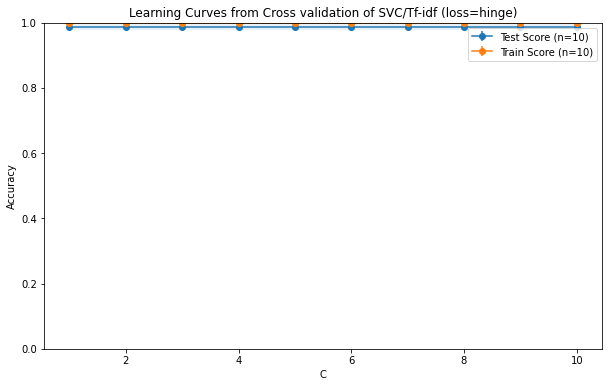

In [ ]:

plt.figure(figsize=(10,6))
temp_tree_cv_results.sort_values(by='C',inplace=True)
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='hinge']
plt.fill_between(resultsSVC['C'],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC['C'],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC['C'],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC['C'],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC/Tf-idf (loss=hinge)')

### Learning curve for different parameters of C at using a Squared Hinge Loss
* From the following graph, we can see that the average test score is converging towards the average train score as the C value reaches 3 with loss='squared_hinge'.

Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC/Tf-idf (loss=squared_hinge)')

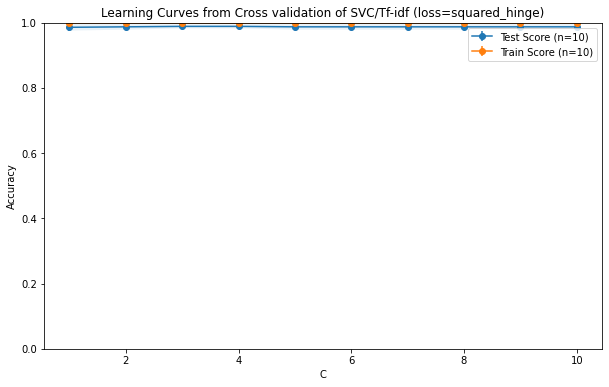

In [ ]:
plt.figure(figsize=(10,6))
temp_tree_cv_results.sort_values(by='C',inplace=True)
resultsSVC=temp_tree_cv_results[temp_tree_cv_results['loss']=='squared_hinge']
plt.fill_between(resultsSVC['C'],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC['C'],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC['C'],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC['C'],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('C')
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC/Tf-idf (loss=squared_hinge)')

## Scoring : 
#### Implementing the Tf-idf and SVC algorithm with the optimal hyper parameters determined from grid search. We train the model using the vectorized X train data and Y train. We predict the results using the vectorized X test data.
#### This tuned model will be used to predict the true test/holdout data. 

In [ ]:
clf=LinearSVC(C=3,loss='squared_hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

#### Confusion matrix and Classification report for the Tf-idf/SVC(C=3,loss='squared_hinge') classifier's performance. 

In [ ]:
 print(confusion_matrix(y_test,predictions)) 
    

[[51  0  1  1  0]
 [ 0 71  0  0  0]
 [ 1  0 54  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  0 57]]


In [ ]:
 print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.98      0.96      0.97        53
      carroll-alice       1.00      1.00      1.00        71
chesterton-thursday       0.98      0.98      0.98        55
    milton-paradise       0.98      1.00      0.99        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.99       300
          macro avg       0.99      0.99      0.99       300
       weighted avg       0.99      0.99      0.99       300



In [ ]:
def plot_ROC(y_test,predictions,title):
  y_test_labelled = label_binarize(y_test, classes=['chesterton-thursday', 'carroll-alice', 'shakespeare-hamlet', 'bryant-stories', 'milton-paradise'])
  predictions_labelled = label_binarize(predictions, classes=['chesterton-thursday', 'carroll-alice', 'shakespeare-hamlet', 'bryant-stories', 'milton-paradise'])
  classes=['chesterton-thursday', 'carroll-alice', 'shakespeare-hamlet', 'bryant-stories', 'milton-paradise']
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(5):
      fpr[i], tpr[i], _ = roc_curve(y_test_labelled[:, i], predictions_labelled[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test_labelled.ravel(), predictions_labelled.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  plt.figure(figsize=(10,6))
  for i in range(5):  
      plt.plot(fpr[i], tpr[i], label=str(classes[i])+': (area = %0.2f)' % roc_auc[i])
      plt.plot([0, 1], [0, 1], 'k--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('ROC on Test Data'+str(title))
      plt.legend( bbox_to_anchor=(1.05, 1), loc='upper left') 

### ROC Curve:
A Receiver Operating Characteristic curve is a graph that shows the performance of a classification model for different classes based on the true positive and false positive rates.
* The areas covered in the below plot for each class show that the model can properly classify 16th century classics such as Shakespeare-Hamlet and Milton-paradise while it could misclassify modern writing styles.

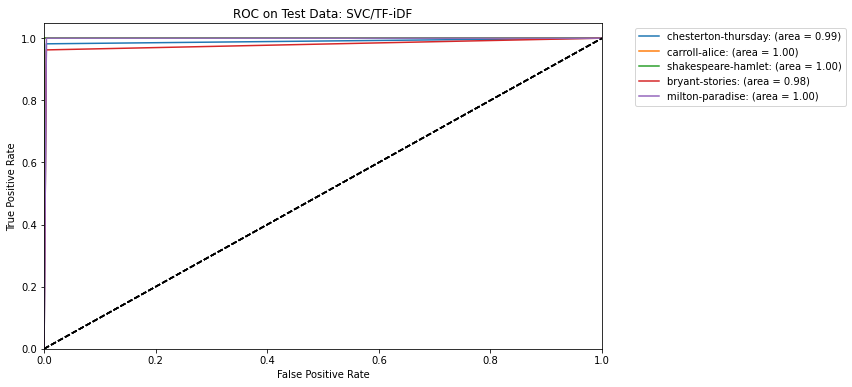

In [ ]:
plot_ROC(y_test,predictions,': SVC/TF-iDF')

In [ ]:
totalListoferrors=pd.DataFrame(columns=['input','predictions','labels'])
for input, prediction, label in zip(x_test, predictions, y_test):
  if prediction != label:
    listOfErrors=[input,prediction,label]
    totalListoferrors.loc[len(totalListoferrors)]=listOfErrors

## Error Analysis
Error Analysis is used to determine the misclassifications made by the model and identify the causes for such a misclassification, in order to define an approach to fix them.

The following is the list of misclassified labels

In [ ]:
totalListoferrors.groupby(by=['predictions','labels']).count()

,,input
predictions,labels,
bryant-stories,chesterton-thursday,1
chesterton-thursday,bryant-stories,1
milton-paradise,bryant-stories,1


#### The Visualizations shown below are done using word clouds on the 3 mistakes made by the classifier.
A passages from chestorton-thursday was misclassified as bryant-stories and two passages from bryant-stories were misclassified as chesterton-thursday and milton-paradise.
* Reason 1: In the following visualizations, some of the high frequency words in the passages seem to be stopwords. Since stop words are not unique to a writing style, this could have lead to a misclassification. (We haven't removed stopwords as they could serve as keywords in 16th century classics such as Hamlet)
* Reason 2: The specific passage might have words which are not repeated elsewhere throughout the actual book, but could be present in the predicted book that it is classified as. This could be causing the misclassification.
Ex. the word 'giantmaidens' from chesterton-thursday passage could be only present in that passage of the book, but there is a chance that the word is available in bryant-stories. 

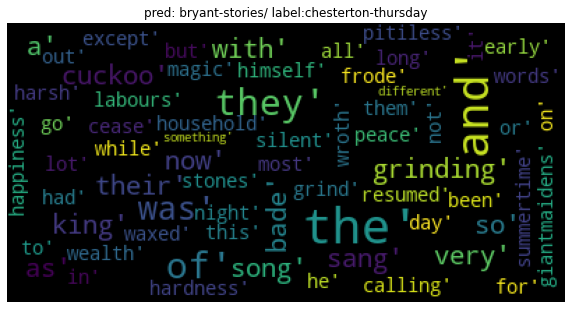

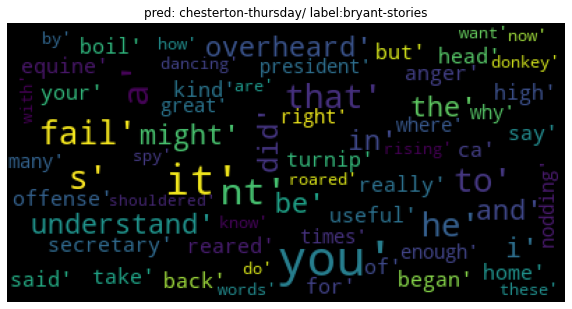

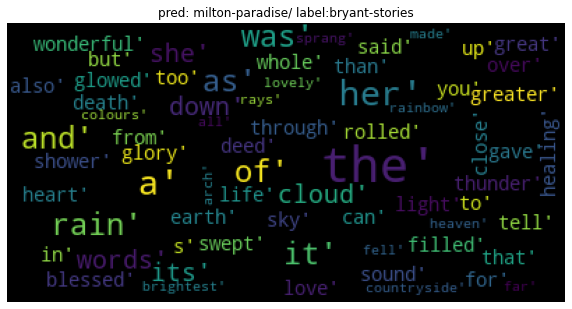

In [ ]:
wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[0])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: bryant-stories/ label:chesterton-thursday'	)
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[1])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: chesterton-thursday/ label:bryant-stories')
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[2])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: milton-paradise/ label:bryant-stories')
plt.show()


#### Unigrams and Bigrams:
The following function shows the most frequently occuring words - alone(unigram) or together in pairs of two(bigrams).


In [ ]:

def plot_unigram_bigram(corpus_test_highesterror,pred_title):
  lst_tokens = nltk.tokenize.word_tokenize(corpus_test_highesterror)
  dic_words_freq = nltk.FreqDist(lst_tokens)
  fig, ax = plt.subplots(nrows=1, ncols=2)
  fig.suptitle("Most frequent words in pred:"+pred_title, fontsize=15)
  dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                    kind="barh", title="Unigrams", ax=ax[0], 
                    legend=False).grid(axis='x')
  ax[0].set(ylabel=None)

      
  ## bigrams
  dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
  dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                        columns=["Word","Freq"])
  dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                    string for string in x) )
  dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                    kind="barh", title="Bigrams", ax=ax[1],
                    legend=False).grid(axis='x')
  ax[1].set(ylabel=None)
  plt.subplots_adjust(wspace=0.6,hspace=1,right=1)
  plt.show()
  fig.tight_layout(pad=10.0)

#### From the plotted graph, we can see that the most frequently occuring unigrams and bigrams are stopwords and their combinations, which gives further insight for the resulting misclassification.

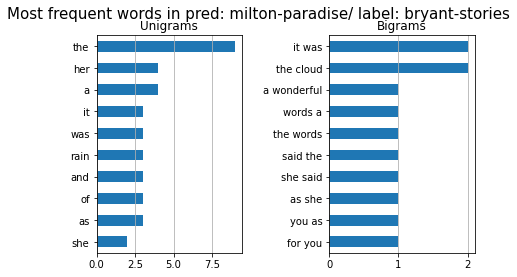

In [ ]:
temp=corpus_test_highesterror=totalListoferrors[(totalListoferrors['predictions']=='milton-paradise')]['input'].values[0]
plot_unigram_bigram(temp,' milton-paradise/ label: bryant-stories')



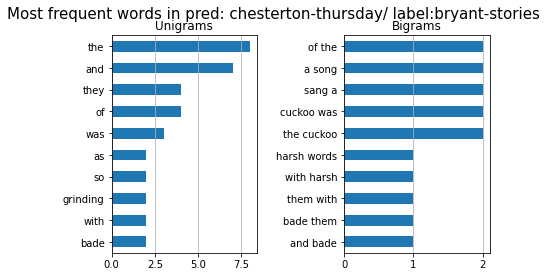

In [ ]:

temp=corpus_test_highesterror=totalListoferrors[(totalListoferrors['predictions']=='chesterton-thursday')]['input'].values[0] 
plot_unigram_bigram(temp,' chesterton-thursday/ label:bryant-stories')



### Summary of results from TF-IDF/SVC
* Grid search performed has shown that the optimal hyper parameters values is C=3 and loss ='squared_hinge'.
* From training/CV: There does not seem to be any overfitting from the cross validation data ( test accuracy and train accuracy very similar during cross validation). The visualized Learning Curve graph also justifies how the model is well-fit for the given data.
* The ROC curve: shows how 16th century classics could be classified better than the modern style writings.
* For the actual testing data: majority of the values of the confusion matrix is in the diagonal, and our prediction can predict the label correctly 99% of the time for new data! 
* Error analysis: The visualizations showing the word clouds and unigrams/bigrams show the potential influence of stopwords on the misclassification.
* The SVC model with TF-IDF vectorization is pretty good! 

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Random Forest Algorithm- TF-IDF
Random forest is a supervised learning algorithm which operates on a large number of decision trees grouped together. Each individual tree returns class predictions and the class with the most votes will be selected. Since the correlation between the models is low, this algorithm is prone to less errors.
### Hyper parameter tuning and cross validation with grid search: 
* We are performing the hyper parameter tuning on:
 * whether to use bootstrap
 * n_estimators (5-500)
* The number of trees is set using the n_estimators parameter which is by default set to 100. With increase in the number of trees the performance usually stabilizes.
* If bootstrap parameter is set to True then bootstrap samples are used. If false, training dataset is used to build the trees. 
* Note that we did not investigate other parameters such as tree depth or number of split. We used the default values of 100 and 2 for those. 
* Use a grid search to search for the best combination of these parameters 
* During this grid search we try each of the parameter combination on 10 cross validations 
* This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

In [ ]:
 RFparameters = {
  'bootstrap':['True','False'],
  'n_estimators': [5,10,50,100,250,500],
  }
clf=RandomForestClassifier(random_state=20) 
grid_searchRF=GridSearchCV(clf,RFparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_searchRF.fit(tfidf_train_data,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=20,
                                 

#### Grid search results returned for  TF-IDF and Random Forest algorithm.
Instead of showing the detailed analysis of grid search results to select best parameters (as shown with SVC and TFIDF), we can also use best_params_ with the grid search object to yield the same result.

In [ ]:
results=gridsearchResultstoDf(grid_searchRF)
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']
# grid_searchRF.best_params_

{'bootstrap': 'True', 'n_estimators': 250}

### Effect of number of trees against performance 
* From the first learning curve, with bootstrap = False we see that the optimal parameter is at n_estimators = 250, because the mean test score seems to slightly decrease with increase in number of trees from that point onwards.
* From the second learning curve, with bootstrap = False, the mean test score doesn't drop, so the parameter value doesn't seem to have an effect.

In [ ]:
temp_tree_cv_results=results
temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=False)')

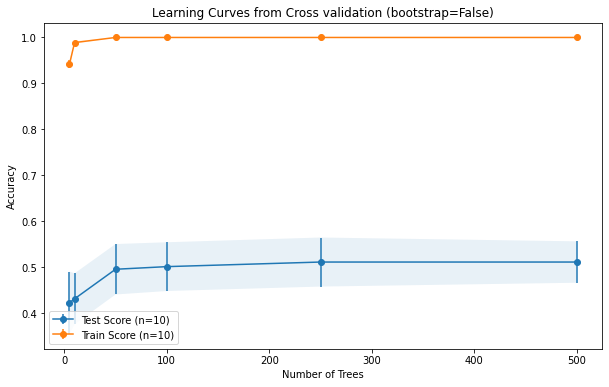

In [ ]:
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapFalse_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean test score']-bootstrapFalse_cv_results['test sdv'],bootstrapFalse_cv_results['mean test score']+bootstrapFalse_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean train score']-bootstrapFalse_cv_results['train sdv'],bootstrapFalse_cv_results['mean train score']+bootstrapFalse_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=False)')

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=True)')

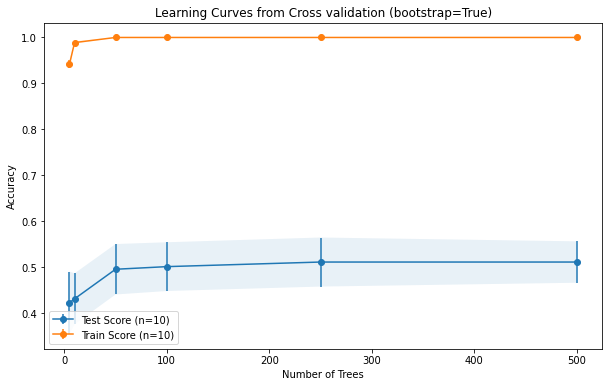

In [ ]:
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapTrue_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']
plt.fill_between(bootstrapTrue_cv_results['n_estimators'],bootstrapTrue_cv_results['mean test score']-bootstrapTrue_cv_results['test sdv'],bootstrapTrue_cv_results['mean test score']+bootstrapTrue_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapTrue_cv_results['n_estimators'],bootstrapTrue_cv_results['mean train score']-bootstrapTrue_cv_results['train sdv'],bootstrapTrue_cv_results['mean train score']+bootstrapTrue_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=True)')

# Scoring:
### Using the optimal parameters from cross validation for prediction

In [ ]:
clf=RandomForestClassifier (bootstrap=True, n_estimators= 250)
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)    

### Evaluation using confusion matrix and classification report 

In [ ]:
print(confusion_matrix(y_test,predictions)) 
    

[[34 10  6  3  3]
 [17 31  5  2  3]
 [33  7 11  3  5]
 [26  4  4 21 11]
 [10 11 11  2 27]]


In [ ]:
 print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.28      0.61      0.39        56
      carroll-alice       0.49      0.53      0.51        58
chesterton-thursday       0.30      0.19      0.23        59
    milton-paradise       0.68      0.32      0.43        66
 shakespeare-hamlet       0.55      0.44      0.49        61

           accuracy                           0.41       300
          macro avg       0.46      0.42      0.41       300
       weighted avg       0.47      0.41      0.41       300



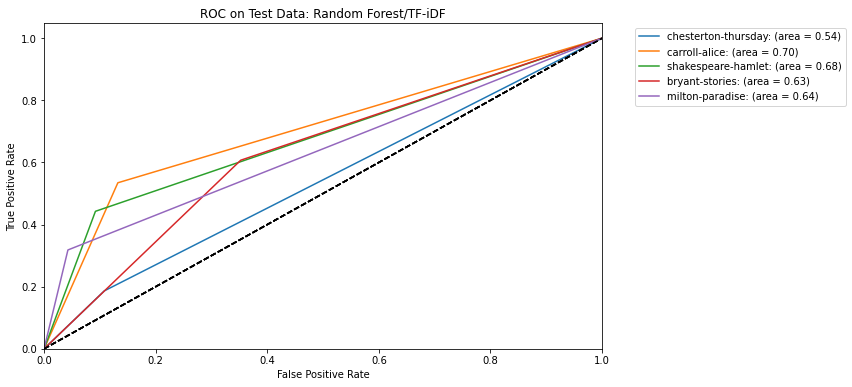

In [ ]:
plot_ROC(y_test,predictions,': Random Forest/TF-iDF')

### Summary of results from Tf-idf/Random Forest 
* Grid search performed has shown that the optimal hyper parameters values is using bootstrap and 250 trees 
* From training/CV:
    * For certain CV, 100 trees had better prediction on the test data comared to 250 trees (such as CV2 ).
    * This decrease in test performance for certain data split indicates signs of overfitting.
    * We speculate that the optimal number of trees should be in between 100-250 trees.
* For the actual testing data: there was sparse value thorughout the matrix and not just on the diagonal, and our prediction can predict the label correctly 73% of the time for new data. 
* Unfortunately, we would not recommend this classifer at this accruacy level.
 

-----------------------------------------------------------------------------------------------------------

# Naive-Bayes Algorithm with TF-IDF
Naive Bayes Classifier uses probabilities to predict the outcome. The name basically implies that the outcome of one feature is independent of occurences of other features.
### Hyper parameter tuning and cross validation 
* we are performing hyper parameter tuning on:
 * var_smoothing 
* var_smoothing or laplace smoothing is used to solve the problem of occurence of zeroes that result from frequency based probabilities. The zeroes appear when a combination of feature and a class variable is not available.
* Use a grid search to identify the best combination of these parameters 
* During this grid search we try each of the parameter combination on 10 cross validations 
* This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

In [ ]:
nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
   
grid_searchNB=GridSearchCV(nb_classifier,params_NB,cv=10,return_train_score=True,scoring='accuracy')
grid_searchNB.fit(tfidf_train_data.todense(),y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [ ]:
results=gridsearchResultstoDf(grid_searchNB)
results.sort_values(by='mean test score')
results[results['mean test score']==results['mean test score'].max()].iloc[0]['param']

{'var_smoothing': 0.1}

Text(0.5, 1.0, 'Learning Curves from Cross validation ')

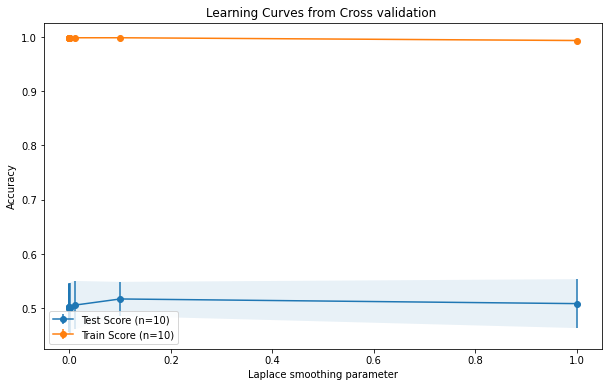

In [ ]:
temp_nb_cv_results=results
temp_nb_cv_results[['var_smoothing']]=results['param'].apply(pd.Series)
temp_nb_cv_results['test sdv']=results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_nb_cv_results['train sdv']=results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

results.sort_values(by='var_smoothing',inplace=True)
bootstrapTrue_cv_results=temp_nb_cv_results
plt.figure(figsize=(10,6))
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score']-temp_nb_cv_results['test sdv'],temp_nb_cv_results['mean test score']+temp_nb_cv_results['test sdv'],alpha=0.1)
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score']-temp_nb_cv_results['train sdv'],temp_nb_cv_results['mean train score']+temp_nb_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score'],temp_nb_cv_results['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score'],temp_nb_cv_results['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Laplace smoothing parameter')
plt.legend()
plt.title('Learning Curves from Cross validation ')

# Scoring:
### Using the optimal parameters from cross validation for prediction

In [ ]:
clf=GaussianNB (var_smoothing= 0.1)
clf.fit(tfidf_train_data.todense(),y_train)
predictions= clf.predict(tfidf_test_data.todense())    


### Evaluation using confusion matrix and classification report 

In [ ]:
 print(confusion_matrix(y_test,predictions)) 
    

[[27 14  9  2  4]
 [ 4 47  3  2  2]
 [13 21 19  3  3]
 [11 17  3 28  7]
 [ 6  9  3  4 39]]


In [ ]:
 print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.89      0.89      0.89        53
      carroll-alice       1.00      0.86      0.92        71
chesterton-thursday       0.87      0.98      0.92        55
    milton-paradise       0.96      1.00      0.98        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.94       300
          macro avg       0.94      0.95      0.94       300
       weighted avg       0.95      0.94      0.94       300



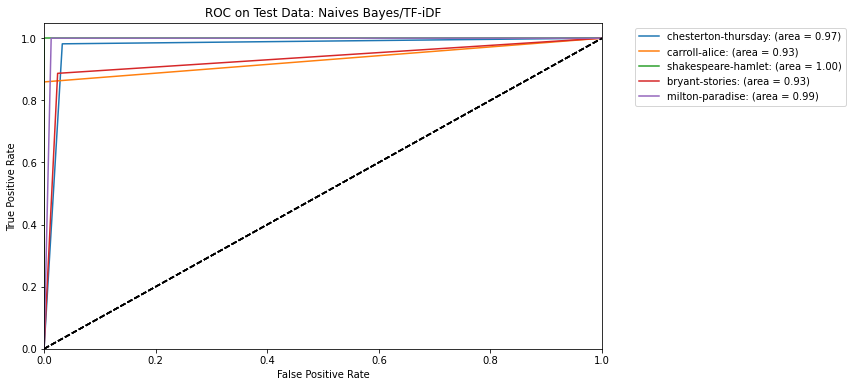

In [ ]:
plot_ROC(y_test,predictions,': Naives Bayes/TF-iDF')

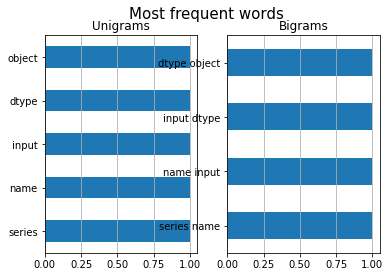

In [ ]:
totalListoferrors.groupby(by=['predictions','labels']).count()


corpus_test_highesterror=totalListoferrors[(totalListoferrors['predictions']=='chesterton-thursday')&(totalListoferrors['labels']=='carroll-alice')]['input']
corpus_test_highesterror=re.sub(r'[^\w\s]', '', str(corpus_test_highesterror).lower().strip())
lst_tokens = nltk.tokenize.word_tokenize(corpus_test_highesterror)
dic_words_freq = nltk.FreqDist(lst_tokens)
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.suptitle("Most frequent words", fontsize=15)
dtf_uni = pd.DataFrame(dic_words_freq.most_common(), 
                       columns=["Word","Freq"])
dtf_uni.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Unigrams", ax=ax[0], 
                  legend=False).grid(axis='x')
ax[0].set(ylabel=None)

    
## bigrams
dic_words_freq = nltk.FreqDist(nltk.ngrams(lst_tokens, 2))
dtf_bi = pd.DataFrame(dic_words_freq.most_common(), 
                      columns=["Word","Freq"])
dtf_bi["Word"] = dtf_bi["Word"].apply(lambda x: " ".join(
                   string for string in x) )
dtf_bi.set_index("Word").iloc[:10,:].sort_values(by="Freq").plot(
                  kind="barh", title="Bigrams", ax=ax[1],
                  legend=False).grid(axis='x')
ax[1].set(ylabel=None)
plt.show()

 ### Summary of results from Tf-idf/Naives-Bayes
* Grid search performed has shown that the optimal hyper parameters values is using var_smoothing of 0.01
* From training/CV: The test results were similar for most of the var_smoothing parameters. However we recommmend exploring var_smoothing value of equal of below 0.1. 
* For the actual testing data: For the confusion matrix majority of the data was on the diagonal, and our prediction can predict the label correctly 97% of the time for new data. 
* Although we've seen better accuracy with SVC, this is also a great classifer!
 

---------------------------------------------------------------------------------------

## Explore these three algorithms with Bag of words feature selection 

### Feature Selection : Using Bag of words to transform our X (Passages) into vectors
####  We have already performed train/test split. We will directly apply this feature transformation on both of our x_train and x_test data.

In [ ]:
vec = CountVectorizer(binary=True)
countvect_train_data = vec.fit_transform(x_train) 
countvect_test_data = vec.transform(x_test)

### SVC Algorithm - Bag of words
### Hyper parameter tuning and cross validation 
* hyper parameter tuning on:
 * C
 * type of loss 
* use a grid search to search for the best combination of these parameters 
*  During this grid search we try each of the parameter combination on 10 cross validations 
*  This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

In [ ]:

SVCparameters = {
  'C':[1,5,10],
  'loss': ['squared_hinge','hinge'], 
  }
clf=LinearSVC() 
grid_search=GridSearchCV(clf,SVCparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_search.fit(countvect_train_data,y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                 fit_intercept=True, intercept_scaling=1,
                                 loss='squared_hinge', max_iter=1000,
                                 multi_class='ovr', penalty='l2',
                                 random_state=None, tol=0.0001, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 5, 10], 'loss': ['squared_hinge', 'hinge']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

#### Grid search results returned for  Bag of words and SVC algorithm.
All results are sorted by the worse to best test scores averaged from the 10-Fold Cross Validation. 

#### Grid search results returned for Bag of words and Random Forest algorithm.
All results are sorted by the worse to best test scores averaged from the 10-Fold Cross Validation. 

In [ ]:
results=gridsearchResultstoDf(grid_search)

what


Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC /Bag of words/hinge loss')

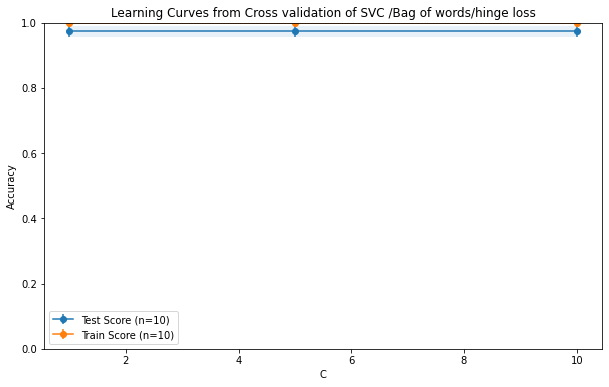

In [ ]:
temp_SVC_cv_results=results
temp_SVC_cv_results[['C','loss']]=temp_SVC_cv_results['param'].apply(pd.Series)
temp_SVC_cv_results['test sdv']=temp_SVC_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_SVC_cv_results['train sdv']=temp_SVC_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
temp_SVC_cv_results['loss']=='hinge'
plt.figure(figsize=(10,6)) 
param='C'
results.copy().sort_values(by=param,inplace=True)
resultsSVC=results[results['loss']=='hinge']
print('what')
plt.fill_between(resultsSVC[param],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC[param],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC[param],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC[param],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel(param)
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC /Bag of words/hinge loss')

what


Text(0.5, 1.0, 'Learning Curves from Cross validation of SVC /Bag of words/squared hinge loss')

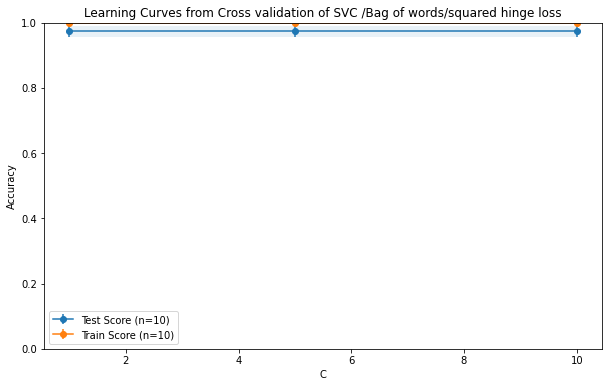

In [ ]:
temp_SVC_cv_results=results
temp_SVC_cv_results[['C','loss']]=temp_SVC_cv_results['param'].apply(pd.Series)
temp_SVC_cv_results['test sdv']=temp_SVC_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_SVC_cv_results['train sdv']=temp_SVC_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
plt.figure(figsize=(10,6)) 
param='C'
results.copy().sort_values(by=param,inplace=True)
resultsSVC=results[results['loss']=='squared_hinge']
print('what')
plt.fill_between(resultsSVC[param],resultsSVC['mean test score']-resultsSVC['test sdv'],resultsSVC['mean test score']+resultsSVC['test sdv'],alpha=0.1)
plt.fill_between(resultsSVC[param],resultsSVC['mean train score']-resultsSVC['train sdv'],resultsSVC['mean train score']+resultsSVC['train sdv'],alpha=0.1)
plt.errorbar(resultsSVC[param],resultsSVC['mean test score'],resultsSVC['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(resultsSVC[param],resultsSVC['mean train score'],resultsSVC['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel(param)
plt.legend()
plt.ylim(0,1)
plt.title('Learning Curves from Cross validation of SVC /Bag of words/squared hinge loss')

# Scoring:
#### Confusion matric/ Classification report of the Bag of word/SVC( C=10,loss='hinge') classifier's performance. 

In [ ]:
clf=LinearSVC(C=10,loss='hinge')
clf.fit(countvect_train_data,y_train)
predictions= clf.predict(countvect_test_data)    

In [ ]:
 print(confusion_matrix(y_test,predictions))

[[47  2  3  1  0]
 [ 0 71  0  0  0]
 [ 0  0 55  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  1 56]]


In [ ]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       1.00      0.89      0.94        53
      carroll-alice       0.97      1.00      0.99        71
chesterton-thursday       0.95      1.00      0.97        55
    milton-paradise       0.97      1.00      0.98        64
 shakespeare-hamlet       1.00      0.98      0.99        57

           accuracy                           0.98       300
          macro avg       0.98      0.97      0.98       300
       weighted avg       0.98      0.98      0.98       300



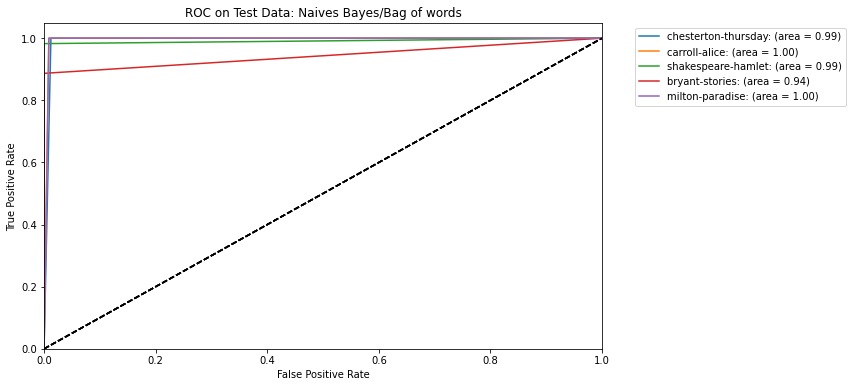

In [ ]:
plot_ROC(y_test,predictions,': Naives Bayes/Bag of words')

### Summary of results from Bag of words/SVC
* Grid search performed has shown that the optimal hyper parameters values is C=10 and loss ='hinge'.
* From training/CV: There does not seem to be any overfitting from the cross validation data ( test accuracy and train accuracy very similar during cross validation) .
* For the actual testing data: majority of the values of the confusion matrix is in the diagonal, and our prediction can predict the label correctly 99% of the time for new data! 
* Bag of word/SVC generated the same prediction results as Tf-idf/SVC! The focus is therefore the use of SVC, and the two different type of feature selection does not impact the results as much in this case.

### Random Forest Algorithm- Bag of word
### Hyper parameter tuning and cross validation with grid search: 
* hyper parameter tuning on:
 * whether to use bootstrap
 * number of trees  (5-500)
* Note that we did not investigate other parameters such as tree depth or number of split. We used the default values of 100 and 2 for those. 
* use a grid search to search for the best combination of these parameters 
*  During this grid search we try each of the parameter combination on 10 cross validations 
*  This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

#### Grid search results returned for Bag of words and Random Forest algorithm.
All results are sorted by the worse to best test scores averaged from the 10-Fold Cross Validation. 

In [ ]:
  RFparameters = {
  'bootstrap':['True','False'],
  'n_estimators': [5,10,50,100,250,500]
  } 
grid_searchRF=GridSearchCV(RandomForestClassifier() ,RFparameters,cv=10,return_train_score=True,scoring='accuracy')
grid_searchRF.fit(countvect_train_data,y_train)
results=gridsearchResultstoDf (grid_searchRF)

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=False)')

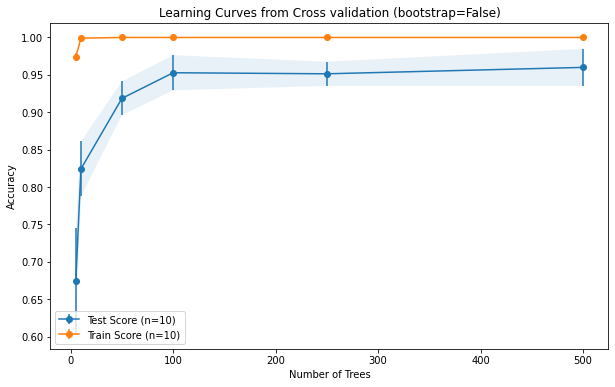

In [ ]:
temp_tree_cv_results=results
temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapFalse_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean test score']-bootstrapFalse_cv_results['test sdv'],bootstrapFalse_cv_results['mean test score']+bootstrapFalse_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean train score']-bootstrapFalse_cv_results['train sdv'],bootstrapFalse_cv_results['mean train score']+bootstrapFalse_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=False)')

Text(0.5, 1.0, 'Learning Curves from Cross validation (bootstrap=True)')

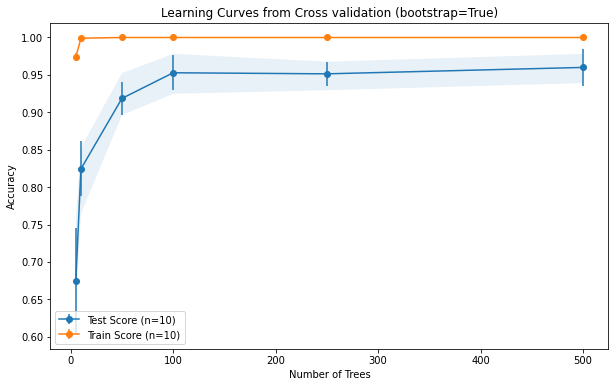

In [ ]:
temp_tree_cv_results=results
temp_tree_cv_results[['bootstrap','n_estimators']]=temp_tree_cv_results['param'].apply(pd.Series)
temp_tree_cv_results['test sdv']=temp_tree_cv_results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_tree_cv_results['train sdv']=temp_tree_cv_results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)
fig = plt.figure(num=1,figsize=(10,6))
temp_tree_cv_results.sort_values(by='n_estimators',inplace=True)
bootstrapFalse_cv_results=temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='True']
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean test score']-bootstrapFalse_cv_results['test sdv'],bootstrapFalse_cv_results['mean test score']+bootstrapFalse_cv_results['test sdv'],alpha=0.1)
plt.fill_between(bootstrapFalse_cv_results['n_estimators'],bootstrapFalse_cv_results['mean train score']-bootstrapFalse_cv_results['train sdv'],bootstrapFalse_cv_results['mean train score']+bootstrapFalse_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean test score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['n_estimators'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['mean train score'],temp_tree_cv_results[temp_tree_cv_results['bootstrap']=='False']['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Number of Trees')
plt.legend()
plt.title('Learning Curves from Cross validation (bootstrap=True)')

# Scoring:
### Using the optimal parameters from cross validation for prediction

In [ ]:
clf=RandomForestClassifier(bootstrap=True,n_estimators=250)
clf.fit(countvect_train_data.todense(),y_train)
predictions= clf.predict(countvect_test_data.todense())    


#### Confusion matric/ Classification report of the Bag of words/Random Forest ( trees=500, no bootstrapping) classifier's performance. 

In [ ]:
 print(confusion_matrix(y_test,predictions)) 
    

[[45  2  2  3  1]
 [ 0 71  0  0  0]
 [ 3  0 51  1  0]
 [ 0  0  0 64  0]
 [ 0  0  0  1 56]]


In [ ]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.94      0.85      0.89        53
      carroll-alice       0.97      1.00      0.99        71
chesterton-thursday       0.96      0.93      0.94        55
    milton-paradise       0.93      1.00      0.96        64
 shakespeare-hamlet       0.98      0.98      0.98        57

           accuracy                           0.96       300
          macro avg       0.96      0.95      0.95       300
       weighted avg       0.96      0.96      0.96       300



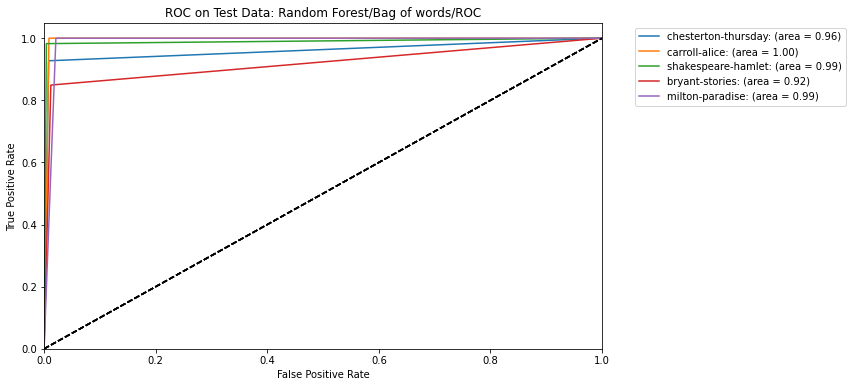

In [ ]:
plot_ROC(y_test,predictions,': Random Forest/Bag of words/ROC')

 ### Summary of results from Bag of words/ Random Forest
* Grid search performed has shown that the optimal hyper parameters values is using 500 trees and no bootstrap
* For certain CV, 100 trees had better prediction on the test data comared to 500 trees (such as CV2 ).
    * This decrease in test performance for certain data split indicates signs of overfitting (high variance)
    * We speculate that the optimal number of trees should be in between 100-500 trees.
* For the actual testing data: For the confusion matrix majority of the data was on the diagonal, and our prediction can predict the label correctly 96% of the time for new data. 
* Bag-of-word with Random forest has resulted significantly higher results compared to Tf-idf with Random Forest (95% Vs 71% accuracy). In this case, Bag of words is a better feature selection method with Random Forest.
 

----------------------------------------------------------------------------------------

### Naives-Bayes Algorithm with Bag of words
### Hyper parameter tuning and cross validation 
* hyper parameter tuning on:
 * var_smoothing 
* use a grid search to search for the best combination of these parameters 
*  During this grid search we try each of the parameter combination on 10 cross validations 
*  This cross validation is splitting the training data into 10 seperate parts, and holding one part out for testing each time 

In [ ]:
nb_classifier = GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}
   
grid_searchNB=GridSearchCV(nb_classifier,params_NB,cv=10,return_train_score=True,scoring='accuracy')
grid_searchNB.fit(countvect_train_data.todense(),y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=GaussianNB(priors=None, var_smoothing=1e-09),
             iid='deprecated', n_jobs=None,
             param_grid={'var_smoothing': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06, 1.e-07,
       1.e-08, 1.e-09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

#### Grid search results returned for Bag of words and Naives-Bayes algorithm.
All results are sorted by the worse to best test scores averaged from the 5-Fold Cross Validation. 

In [ ]:
results=gridsearchResultstoDf(grid_searchNB)

### Learning Curve

Text(0.5, 1.0, 'Learning Curves from Cross validation ')

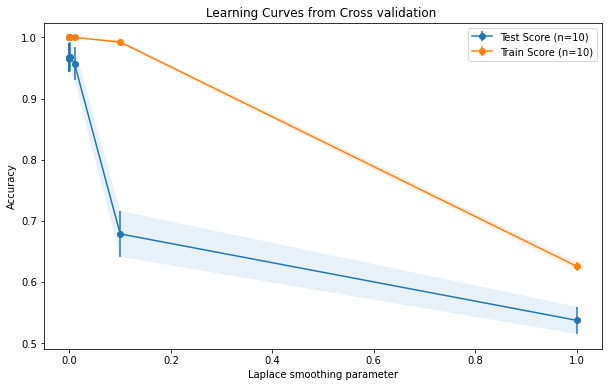

In [ ]:
temp_nb_cv_results=results
temp_nb_cv_results[['var_smoothing']]=results['param'].apply(pd.Series)
temp_nb_cv_results['test sdv']=results[['CV1 test loss','CV2 test loss','CV3 test loss','CV4 test loss','CV5 test loss','CV6 test loss','CV7 test loss','CV9 test loss','CV10 test loss']].std(axis=1)
temp_nb_cv_results['train sdv']=results[['CV1 train loss','CV2 train loss','CV3 train loss','CV4 train loss','CV5 trainloss','CV6 train loss','CV7 train loss','CV9 train loss','CV10 train loss']].std(axis=1)

results.sort_values(by='var_smoothing',inplace=True)
bootstrapTrue_cv_results=temp_nb_cv_results
plt.figure(figsize=(10,6))
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score']-temp_nb_cv_results['test sdv'],temp_nb_cv_results['mean test score']+temp_nb_cv_results['test sdv'],alpha=0.1)
plt.fill_between(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score']-temp_nb_cv_results['train sdv'],temp_nb_cv_results['mean train score']+temp_nb_cv_results['train sdv'],alpha=0.1)
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean test score'],temp_nb_cv_results['test sdv'],label='Test Score (n=10)',fmt='-o')
plt.errorbar(temp_nb_cv_results['var_smoothing'],temp_nb_cv_results['mean train score'],temp_nb_cv_results['train sdv'],label='Train Score (n=10)',fmt='-o')
plt.ylabel('Accuracy')
plt.xlabel('Laplace smoothing parameter')
plt.legend()
plt.title('Learning Curves from Cross validation ')

# Scoring
### Using the optimal parameters from cross validation for prediction

In [ ]:
clf=GaussianNB (var_smoothing= 0.001)
clf.fit(countvect_train_data.todense(),y_train)
predictions= clf.predict(countvect_test_data.todense())    


#### Confusion matric/ Classification report of the Bag of words/Naives-Bayes(var_smoothing=0.001) classifier's performance. 

In [ ]:
  print(confusion_matrix(y_test,predictions)) 
    

[[49  1  2  1  0]
 [ 2 68  1  0  0]
 [ 1  0 54  0  0]
 [ 0  0  0 64  0]
 [ 0  0  0  0 57]]


In [ ]:
print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.94      0.92      0.93        53
      carroll-alice       0.99      0.96      0.97        71
chesterton-thursday       0.95      0.98      0.96        55
    milton-paradise       0.98      1.00      0.99        64
 shakespeare-hamlet       1.00      1.00      1.00        57

           accuracy                           0.97       300
          macro avg       0.97      0.97      0.97       300
       weighted avg       0.97      0.97      0.97       300



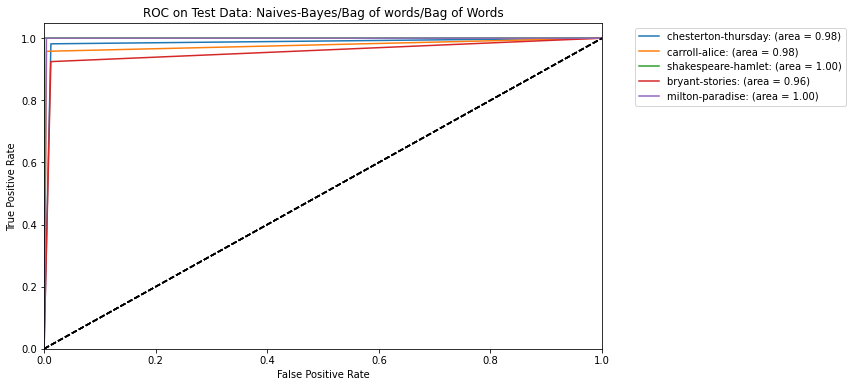

In [ ]:
plot_ROC(y_test,predictions,': Naives-Bayes/Bag of words/Bag of Words')

  ### Summary of results from Bag of words /Naives-Bayes
* Grid search performed has shown that the optimal hyper parameters values is using var_smoothing of 0.001
* From training/CV: The test results were similar for most of the var_smoothing parameters. However we recommmend exploring var_smoothing value of equal of below 0.01. 
* For the actual testing data: For the confusion matrix majority of the data was on the diagonal, and our prediction can predict the label correctly 98% of the time for new data. 
* Bag of words with Naives Bayes has resulted a better value than Tf-idf with Naives Bayes (98% vs 94%)!
 

In [ ]:

totalListoferrors=pd.DataFrame(columns=['input','predictions','labels'])
for input, prediction, label in zip(x_test, predictions, y_test):
  if prediction != label:
    listOfErrors=[input,prediction,label]
    totalListoferrors.loc[len(totalListoferrors)]=listOfErrors
totalListoferrors.groupby(by=['predictions','labels']).count()

input
predictions         labels                    
bryant-stories      carroll-alice            2
                    chesterton-thursday      1
carroll-alice       bryant-stories           1
chesterton-thursday bryant-stories           2
                    carroll-alice            1
milton-paradise     bryant-stories           1

In [ ]:
totalListoferrors

,input,predictions,labels
0,leaves are dark crimson every day they dry a...,chesterton-thursday,bryant-stories
1,first that it came from a man of massive s...,bryant-stories,chesterton-thursday
2,room with many little white beds in it of ch...,carroll-alice,bryant-stories
3,and bade them with harsh words go on grind...,chesterton-thursday,bryant-stories
4,love oh dear what nonsense i m talking ...,bryant-stories,carroll-alice
5,she had expected before she had drunk half t...,chesterton-thursday,carroll-alice
6,leaving alice alone with the gryphon alice...,bryant-stories,carroll-alice
7,some in the reeds of the black mountainlake ...,milton-paradise,bryant-stories


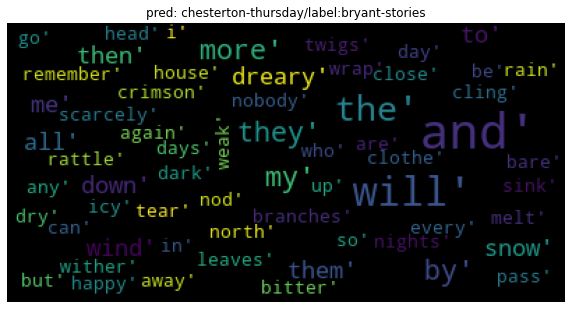

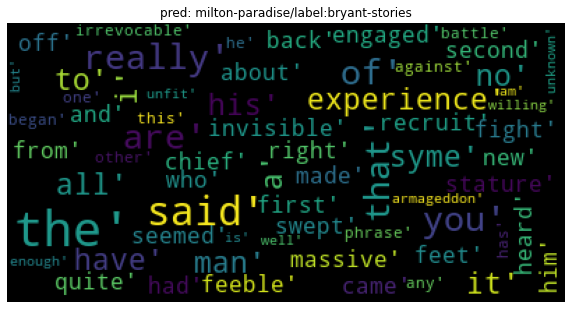

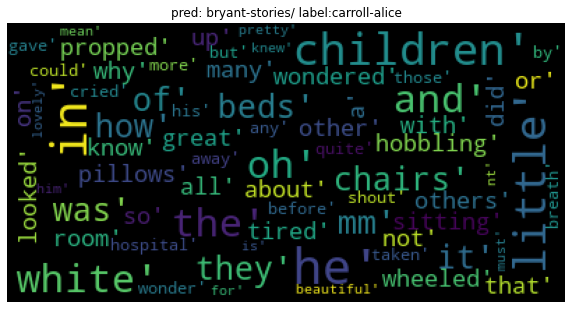

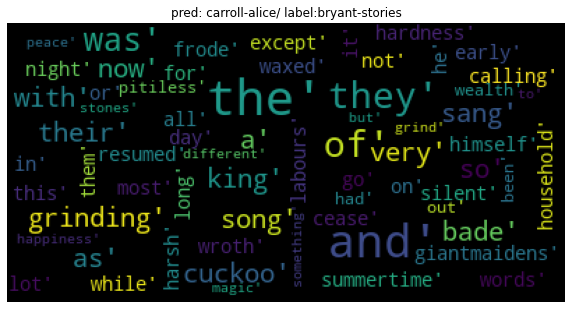

In [ ]:


wordc = wordcloud.WordCloud(background_color='black', max_words=100, 
                         max_font_size=35)
wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[0])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: chesterton-thursday/label:bryant-stories'	)
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[1])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: milton-paradise/label:bryant-stories')
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[2])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: bryant-stories/ label:carroll-alice')
plt.show()

wc = wordc.generate(str(nltk.tokenize.word_tokenize(totalListoferrors['input'].iloc[3])))
fig = plt.figure(num=1,figsize=(10,6))
plt.axis('off')
plt.imshow(wc, cmap=None)
plt.title('pred: carroll-alice/ label:bryant-stories')
plt.show()

#### To conclude:
* The algorithm that yielded the highest accuracy on the test data is SVC. 
* Both SVC with Tf-idf and Bag of words feature selection have yielded 99% accuracy on test data : A Tie!
* For Tf-idf SVC we would recommend using C=5 and squared hinge loss
* For Bag of words SVC we would reccomend using C=10 and hinge loss


### Case study on using short paragraphs for testing

A function to convert the given passages in the data set into short passages of varying lengths for testing the accuracy of the model. 
 

In [ ]:
import re
import nltk
nltk.download('punkt')
def short_passages(n):
  main_set = []
  regex_pattern = re.compile(r'[A-Za-z0-9]+|^\'\w+')
  counter = 0
  result_set = []
  passage = ''
  for i in range(len(df1)):
    words = nltk.word_tokenize(df1['passage'][i])
    for each_word in words:
      if bool(re.match(regex_pattern, each_word)) == True:
        result_set.append(each_word)
        counter += 1 
      else:
        result_set.append(each_word)   
      if counter >= n:
        passage = " ".join(str(item) for item in result_set)
        counter = 0
        result_set = []
        main_set.append(passage)
        break
    short_passage = pd.Series(main_set)
  short_passage = short_passage.rename('passage')
  df1['short_passages'] = short_passage
  return df1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Analysis with 70 words in the passage

In [ ]:
df1 = short_passages(70)
df1

,Unnamed: 0,passage,bookName,short_passages
0,366,all the human things in his story of the chi...,chesterton-thursday,all the human things in his story of the chine...
1,421,four out of the five rich men in this town ...,chesterton-thursday,four out of the five rich men in this town he ...
2,376,care about i did nt care about catching the ...,chesterton-thursday,care about i did nt care about catching the tr...
3,212,take your head home and boil it for a turnip i...,chesterton-thursday,take your head home and boil it for a turnip i...
4,552,my master asks me to say said the attend...,chesterton-thursday,my master asks me to say said the attendant th...
...,...,...,...,...
995,702,draws oer the blue firmament a radiant white ...,milton-paradise,draws oer the blue firmament a radiant white a...
996,711,rear of grassy turf and pile up every stone ...,milton-paradise,rear of grassy turf and pile up every stone of...
997,196,various forms that rolled orbicular and tu...,milton-paradise,various forms that rolled orbicular and turned...
998,618,thy sorrow i will greatly multiply by thy co...,milton-paradise,thy sorrow i will greatly multiply by thy conc...


In [ ]:
 x=df1['short_passages']

In [ ]:
y=df1['bookName']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7)

In [ ]:
 vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x_train) 
tfidf_test_data = vec.transform(x_test)


In [ ]:
 clf=LinearSVC(C=1,loss='hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)

In [ ]:
  print(confusion_matrix(y_test,predictions)) 

[[52  1  2  0  0]
 [ 0 57  1  0  0]
 [ 0  1 57  0  1]
 [ 0  0  0 65  0]
 [ 0  0  0  0 63]]


In [ ]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       1.00      0.95      0.97        55
      carroll-alice       0.97      0.98      0.97        58
chesterton-thursday       0.95      0.97      0.96        59
    milton-paradise       1.00      1.00      1.00        65
 shakespeare-hamlet       0.98      1.00      0.99        63

           accuracy                           0.98       300
          macro avg       0.98      0.98      0.98       300
       weighted avg       0.98      0.98      0.98       300



Analysis with 40 words in the passage

In [ ]:
df1 = short_passages(40)
df1

,Unnamed: 0,passage,bookName,short_passages
0,366,all the human things in his story of the chi...,chesterton-thursday,all the human things in his story of the chine...
1,421,four out of the five rich men in this town ...,chesterton-thursday,four out of the five rich men in this town he ...
2,376,care about i did nt care about catching the ...,chesterton-thursday,care about i did nt care about catching the tr...
3,212,take your head home and boil it for a turnip i...,chesterton-thursday,take your head home and boil it for a turnip i...
4,552,my master asks me to say said the attend...,chesterton-thursday,my master asks me to say said the attendant th...
...,...,...,...,...
995,702,draws oer the blue firmament a radiant white ...,milton-paradise,draws oer the blue firmament a radiant white a...
996,711,rear of grassy turf and pile up every stone ...,milton-paradise,rear of grassy turf and pile up every stone of...
997,196,various forms that rolled orbicular and tu...,milton-paradise,various forms that rolled orbicular and turned...
998,618,thy sorrow i will greatly multiply by thy co...,milton-paradise,thy sorrow i will greatly multiply by thy conc...


In [ ]:
 x=df1['short_passages']

In [ ]:
y=df1['bookName']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7)

In [ ]:
 vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x_train) 
tfidf_test_data = vec.transform(x_test)


In [ ]:
 clf=LinearSVC(C=1,loss='hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)

In [ ]:
  print(confusion_matrix(y_test,predictions)) 

[[47  2  4  0  2]
 [ 0 57  3  0  0]
 [ 7  3 54  2  1]
 [ 2  0  0 61  0]
 [ 0  0  0  0 55]]


In [ ]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.84      0.85      0.85        55
      carroll-alice       0.92      0.95      0.93        60
chesterton-thursday       0.89      0.81      0.84        67
    milton-paradise       0.97      0.97      0.97        63
 shakespeare-hamlet       0.95      1.00      0.97        55

           accuracy                           0.91       300
          macro avg       0.91      0.92      0.91       300
       weighted avg       0.91      0.91      0.91       300



Analysis with 10 words in the passage

In [ ]:
df1 = short_passages(10)
df1

,Unnamed: 0,passage,bookName,short_passages
0,366,all the human things in his story of the chi...,chesterton-thursday,all the human things in his story of the chinese
1,421,four out of the five rich men in this town ...,chesterton-thursday,four out of the five rich men in this town
2,376,care about i did nt care about catching the ...,chesterton-thursday,care about i did nt care about catching the train
3,212,take your head home and boil it for a turnip i...,chesterton-thursday,take your head home and boil it for a turnip
4,552,my master asks me to say said the attend...,chesterton-thursday,my master asks me to say said the attendant that
...,...,...,...,...
995,702,draws oer the blue firmament a radiant white ...,milton-paradise,draws oer the blue firmament a radiant white a...
996,711,rear of grassy turf and pile up every stone ...,milton-paradise,rear of grassy turf and pile up every stone of
997,196,various forms that rolled orbicular and tu...,milton-paradise,various forms that rolled orbicular and turned...
998,618,thy sorrow i will greatly multiply by thy co...,milton-paradise,thy sorrow i will greatly multiply by thy conc...


In [ ]:
 x=df1['short_passages']

In [ ]:
y=df1['bookName']

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7)

In [ ]:
 vec = TfidfVectorizer(binary=True, use_idf=True)
tfidf_train_data = vec.fit_transform(x_train) 
tfidf_test_data = vec.transform(x_test)


In [ ]:
 clf=LinearSVC(C=1,loss='hinge')
clf.fit(tfidf_train_data,y_train)
predictions= clf.predict(tfidf_test_data)

In [ ]:
  print(confusion_matrix(y_test,predictions)) 

[[29 10  8  4  5]
 [ 6 39  6  5  2]
 [16  7 20 11  5]
 [ 5  4  4 42 11]
 [ 2  7  4  6 42]]


In [ ]:
  print(classification_report(y_test,predictions))

                     precision    recall  f1-score   support

     bryant-stories       0.50      0.52      0.51        56
      carroll-alice       0.58      0.67      0.62        58
chesterton-thursday       0.48      0.34      0.40        59
    milton-paradise       0.62      0.64      0.63        66
 shakespeare-hamlet       0.65      0.69      0.67        61

           accuracy                           0.57       300
          macro avg       0.56      0.57      0.56       300
       weighted avg       0.57      0.57      0.57       300



Plotting a graph for the Passage words vs Test Accuracy

In [ ]:
x = [100, 70, 40, 10]
df_words_vs_accuracy=pd.DataFrame(columns={'Passage Length (words)','Number of words vs Accuracy'})
for allX in x:
    df1 =short_passages(allX)
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,train_size=0.7)
    vec = TfidfVectorizer(binary=True, use_idf=True)
    tfidf_train_data = vec.fit_transform(x_train) 
    tfidf_test_data = vec.transform(x_test)
    clf=LinearSVC(C=1,loss='hinge')
    clf.fit(tfidf_train_data,y_train)
    predictions= clf.predict(tfidf_test_data)
    temp=[]
    temp.append(allX,accuracy_score(y_test,predictions))
    df_words_vs_accuracy.loc[len]=temp

ValueError: ignored

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

x = [100, 70, 40, 10]
y = [99, 97, 90, 57 ]
plt.title('Number of words vs Accuracy')
plt.xlabel('Passage Length (words)')
plt.ylabel('Accuracy (%)')
plt.plot(x,y)
plt.plot(x,y, marker ='o', markerfacecolor='black')
plt.show()

